# Использование готовых архитектур в Pytorch
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mWFPzsXw4RQ86iZGswmNY45WTSjZcF9u#scrollTo=9ic0H8b8qO5z) -->

## Импорт torch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader, random_split


import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange
import warnings
import pandas as pd

In [4]:
def setup_experiment(
    seed: int = 42,
    deterministic: bool = True,
    benchmark: bool = False,
    allow_tf32: bool = True,
    device_preference: str = "auto"
):
    """
    Настраивает окружение для воспроизводимых экспериментов в PyTorch.

    Args:
        seed (int): Сид для генераторов случайных чисел (Python, NumPy, PyTorch).
        deterministic (bool): Включить детерминированное поведение операций CuDNN (может снизить скорость).
        benchmark (bool): Включить CuDNN benchmark для автоматического выбора быстрых алгоритмов (не совместимо с deterministic=True).
        allow_tf32 (bool): Разрешить использование TensorFloat32 на Ampere+ GPU (ускоряет вычисления с небольшой потерей точности).
        device_preference (str): "cpu", "cuda", "mps", или "auto" — выбор устройства.

    Returns:
        torch.device: Устройство, на котором будут выполняться вычисления.
    """
    # --- 1. Установка сидов ---
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # для multi-GPU

    # --- 2. Настройки CuDNN ---
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic = deterministic
        torch.backends.cudnn.benchmark = benchmark
        # benchmark=True ускоряет обучение, но нарушает воспроизводимость
        # deterministic=True гарантирует воспроизводимость, но может замедлить

    # --- 3. TF32 (только для CUDA на Ampere и новее) ---
    if torch.cuda.is_available() and hasattr(torch.backends.cuda, 'matmul'):
        torch.backends.cuda.matmul.allow_tf32 = allow_tf32
        torch.backends.cudnn.allow_tf32 = allow_tf32

    # --- 4. Подавление некоторых предупреждений (опционально) ---
    warnings.filterwarnings("ignore", category=UserWarning, module="torch")
    # Можно раскомментировать, если мешают предупреждения о нестабильных операциях

    # --- 5. Выбор устройства ---
    if device_preference == "auto":
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        elif torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
    elif device_preference == "cpu":
        device = torch.device("cpu")
    elif device_preference == "cuda":
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            raise RuntimeError("CUDA not available, but 'cuda' was requested.")
    elif device_preference == "mps":
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            raise RuntimeError("MPS not available, but 'mps' was requested.")
    else:
        raise ValueError("device_preference must be 'auto', 'cpu', 'cuda', or 'mps'")

    # --- 6. Печать итоговой конфигурации ---
    print(f"[Setup] Seed: {seed}")
    print(f"[Setup] Device: {device}")
    print(f"[Setup] CuDNN deterministic: {deterministic}, benchmark: {benchmark}")
    if torch.cuda.is_available():
        print(f"[Setup] TF32 enabled: {allow_tf32}")
    print("-" * 50)

    return device

In [5]:
device = setup_experiment()

[Setup] Seed: 42
[Setup] Device: cuda
[Setup] CuDNN deterministic: True, benchmark: False
[Setup] TF32 enabled: True
--------------------------------------------------


# Перенос обучения при помощи моделей torchvision

## Загрузка модели.

In [6]:
# model = torchvision.models.resnet18(pretrained=True)
model = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

Проверим структуру модели

In [7]:
summary(model,input_size=(1,3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

После загрузки модели нужно заморозить все параметры для экстрактора признаков. Для этого нам нужно установить `requires_grad = False`, чтобы заморозить параметры, чтобы градиенты не вычислялись в `backward()`. То есть такой мерой мы предотвращаем возможное переобчение модели.

In [8]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

## Загрузка набора данных

In [9]:
from pathlib import Path
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset

class CSVDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, is_test=False):
        """
        Args:
            csv_file (str): Путь к CSV-файлу.
                - В train/val: колонки ['id', 'label']
                - В test: колонка ['id'] (без 'label')
            root_dir (str): Путь к папке с изображениями.
            transform (callable, optional): Трансформации изображений.
            is_test (bool): Если True — режим инференса (возвращаем filename вместо label).
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.is_test = is_test

        if not self.is_test:
            # Только в обучающем режиме создаём маппинг меток
            self.labels = self.annotations['label'].unique()
            self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
            self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx]['id']
        img_path = self.root_dir / img_name
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, img_name  # возвращаем имя файла как строку
        else:
            label_str = self.annotations.iloc[idx]['label']
            label = self.label_to_idx[label_str]
            return image, label

In [36]:
# Трансформации
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Создаём исходный train датасет
full_train_dataset = CSVDataset(
    csv_file='dataset/train_labels.csv',
    root_dir='dataset/train',
    transform=transform
)

# Параметры разделения
val_ratio = 0.2  # 20% под валидацию
total_train = len(full_train_dataset)
val_size = int(total_train * val_ratio)
train_size = total_train - val_size

# Разделяем
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # для воспроизводимости
)

# Test датасет остаётся как есть
test_dataset = CSVDataset(
    csv_file='dataset/test_labels.csv',
    root_dir='dataset/test',
    transform=transform,
    is_test = True
)
batch_size = 128
# DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Информация
num_classes = len(full_train_dataset.label_to_idx)
idx_to_label = full_train_dataset.idx_to_label
names_classes = list(idx_to_label.values())
print("Классы:", idx_to_label)
print("Число классов:", num_classes)
print(f"Train size: {len(train_dataset)}")
print(f"Val size:   {len(val_dataset)}")
print(f"Test size:  {len(test_dataset)}")

Классы: {0: 'chicken_wings', 1: 'fish_and_chips', 2: 'butterfly', 3: 'cup_cakes', 4: 'bee', 5: 'wasp', 6: 'beetle', 7: 'apple_pie', 8: 'spider', 9: 'Waterbody'}
Число классов: 10
Train size: 4272
Val size:   1067
Test size:  2875


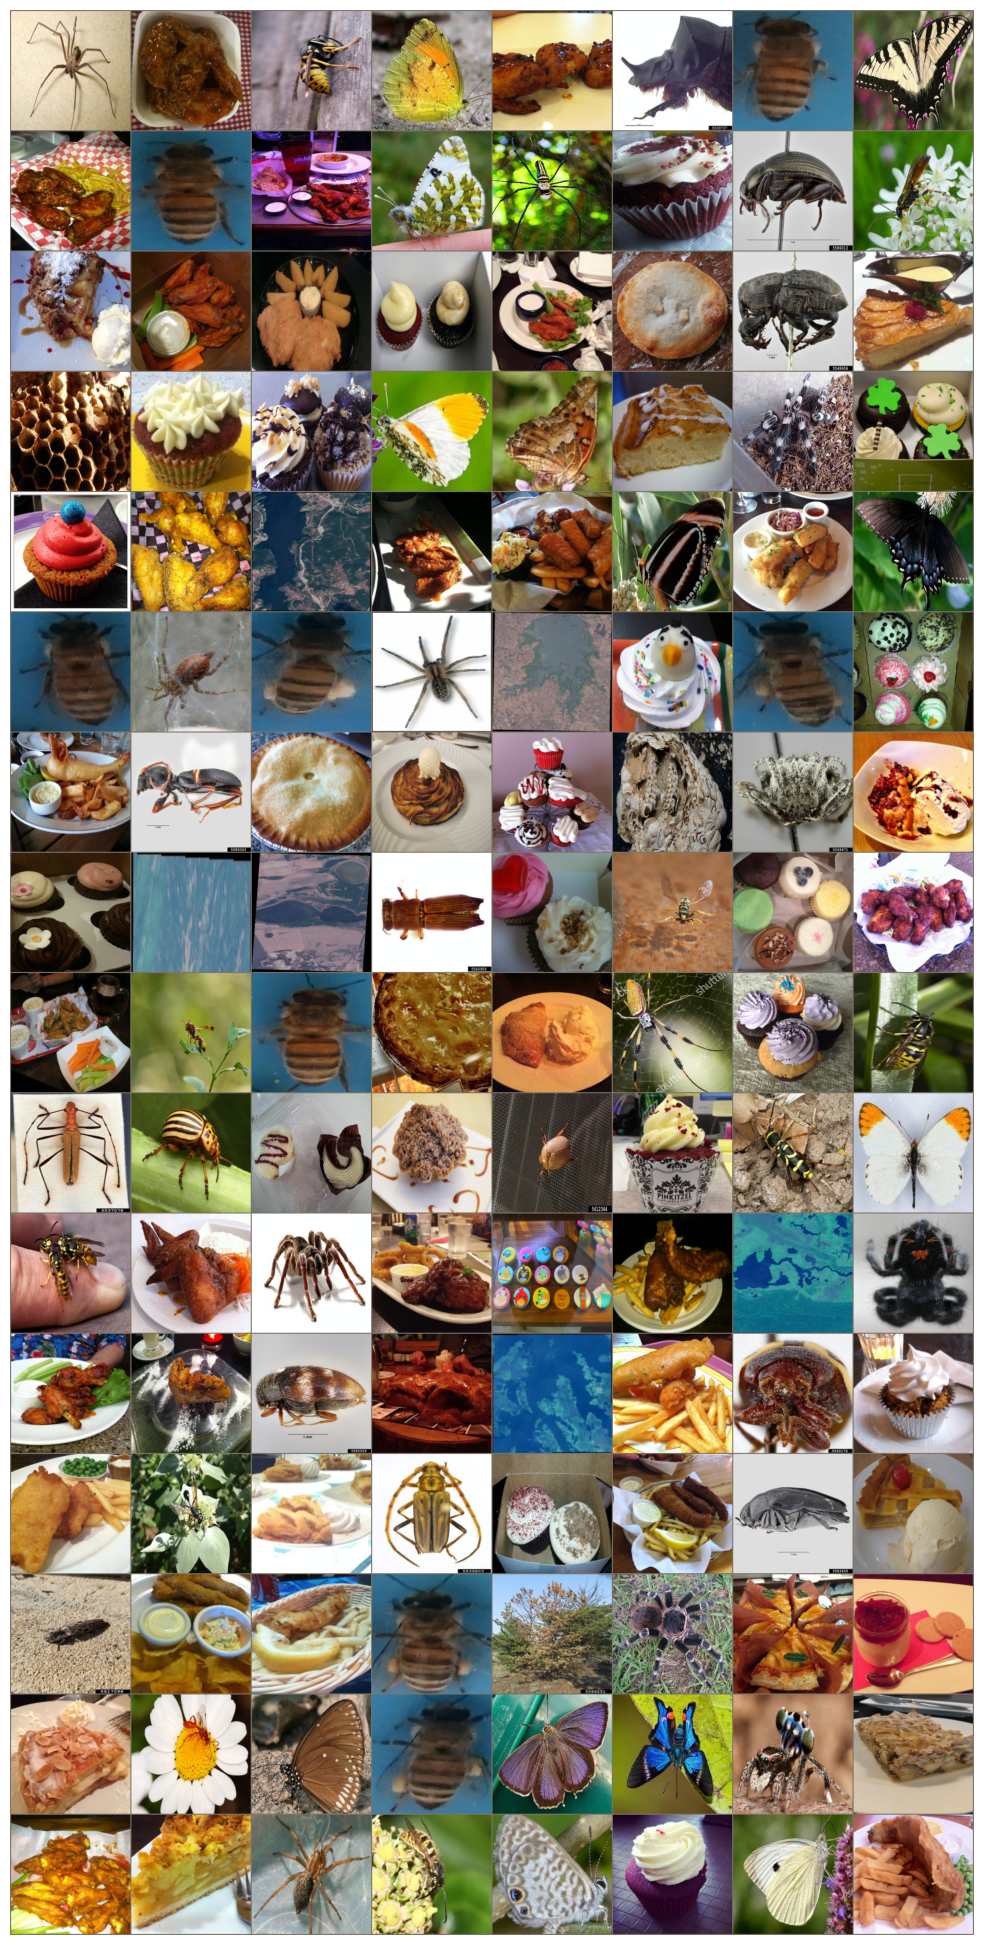

In [39]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(35,25))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, )

## Transfer Learning

После того, как сформирована фиксированная модель можно приступить к разморозке и/или замене части слоев.
Как правило, операриуют только с  головными слоями.

Замним головной слой (`fc`) на свой, представляющий линейный слой с выходом, равным числу классов. 

Для инициализации нового слоя мы должны будем знать размер его входа. Его можно получить как атрибут `in_features` для соответствующего слоя. Также можно проинициализировать параметры слоя. Для весовых параметров используем инициализацию Ксавьера, а для смещения инициализацию нулями.

In [12]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.fc.in_features

model.fc = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0);

Посмотрим теперь на число тренируем и на общее число параметров.

In [13]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 5130
Number of all parameters for the model: 11181642


In [14]:
summary(model,(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

Также выделим тренируемые параметры в отдельный объект.

In [15]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

Запишем параметры обучения.

Отметим, что в данном случае, мы могли бы вместо `trainable_parameters` записать `model.fc.parameters`. Однако, указанный подход более общий.

In [16]:
LR = 0.001

device

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)


Также запишим функционал, необходимый для обучения. Данные функции были уже расмортены на предыдущих уроках.

In [17]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc
    
#-----------------------------
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Проверим, какая точность достигается на тестовых данных в настоящее время 

In [18]:
best_epoch = 0
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

best epoch 0: Test Loss: 4.122 | Test Acc: 9.19%


Теперь проведем обучение согласно стандартной процедуре, рассмотренной нами в предыдущих уроках

In [19]:
def fit(model, train_loader, val_loader, optimizer, 
        criterion, metric, epochs = 10, 
        device='cpu',  path_best = 'best_model.pt', verbose = True):
    
    best_valid_loss = float('inf')
    
    # Инициализация истории обучения
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'epoch_time': []
    }

    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)
        
        # Сохранение метрик в историю
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        history['epoch_time'].append(epoch_mins * 60 + epoch_secs)  # сохраняем время в секундах

        if verbose == True:
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
            f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%') 
    
    return history

In [20]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc
metric    = accuracy

In [21]:
EPOCHS = 10
history = fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = EPOCHS, device=device, verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 1.312 | Train Acc: 58.35%  | Val. Loss: 0.560 | Val. Acc: 83.18%


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 0.522 | Train Acc: 84.10%  | Val. Loss: 0.401 | Val. Acc: 86.77%


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.409 | Train Acc: 87.27%  | Val. Loss: 0.342 | Val. Acc: 87.98%


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.341 | Train Acc: 89.25%  | Val. Loss: 0.312 | Val. Acc: 88.25%


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.310 | Train Acc: 90.32%  | Val. Loss: 0.275 | Val. Acc: 90.35%


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 17s
	Train Loss: 0.290 | Train Acc: 90.88%  | Val. Loss: 0.256 | Val. Acc: 90.36%


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 17s
	Train Loss: 0.268 | Train Acc: 91.30%  | Val. Loss: 0.251 | Val. Acc: 90.91%


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 17s
	Train Loss: 0.256 | Train Acc: 92.02%  | Val. Loss: 0.244 | Val. Acc: 91.37%


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 17s
	Train Loss: 0.251 | Train Acc: 91.65%  | Val. Loss: 0.236 | Val. Acc: 91.00%


Training:   0%|          | 0/134 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 17s
	Train Loss: 0.234 | Train Acc: 92.33%  | Val. Loss: 0.235 | Val. Acc: 91.09%


In [22]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion, accuracy, device)
print(10*'--',f'\n Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

-------------------- 
 Test Loss: 0.235 | Test Acc: 91.09%


Проведенная процедура оказалась достаточно быстрой и дала хорошие результаты.

## Создание файла для отправки

Тут созадна специальная отдельная функция `submit` результат работы которой - это `DataFrame` с двумя колноками:
* `file_name`	- название файла из закрытого набора данных
* `class` - предсказанная метка класса (в формате числа от 0 и выше).

In [23]:
def submit(model, dataloader, device, idx_to_label=None):
    """
    Генерирует submission DataFrame.
    
    Args:
        model: обученная модель PyTorch
        dataloader: DataLoader, возвращающий (image, id)
        device: устройство (cpu/cuda/mps)
        idx_to_label (dict or None): маппинг {индекс_класса: строковое_название}
            Если None — сохраняются числовые индексы.
    
    Returns:
        pd.DataFrame с колонками ['id', 'class']
    """
    model.eval()
    file_names = []
    predictions = []

    with torch.inference_mode():
        for images, filenames in tqdm(dataloader, desc="Inference"):
            images = images.to(device, dtype=torch.float32)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()  # shape: (batch_size,)

            file_names.extend(filenames)
            if idx_to_label is not None:
                # Преобразуем индексы в строковые метки
                str_preds = [idx_to_label[idx] for idx in preds]
                predictions.extend(str_preds)
            else:
                # Оставляем числовые индексы
                predictions.extend(preds.tolist())

    df = pd.DataFrame({
        'id': file_names,
        'class': predictions
    })
    return df

In [24]:
df_ = submit(model, test_loader, device, idx_to_label)

Inference:   0%|          | 0/90 [00:00<?, ?it/s]

In [26]:
df_

id          class
0        1.jpg      apple_pie
1        2.jpg      apple_pie
2        3.jpg         beetle
3        4.jpg         spider
4        5.jpg  chicken_wings
...        ...            ...
2870  2871.jpg      Waterbody
2871  2872.jpg  chicken_wings
2872  2873.jpg            bee
2873  2874.jpg      cup_cakes
2874  2875.jpg  chicken_wings

[2875 rows x 2 columns]

Сохраним результат.

<!-- <code style="color:red">__Большая просьба сохранять результат с указанием ФИО !__ </code> -->

In [27]:
path_submit = 'submit.csv'

df_.rename(columns ={'file_name':'id'}).to_csv(path_submit, index = False )

print('FULL PATH:  \n', os.path.join(os.getcwd(), path_submit) )

FULL PATH:  
 D:\Yandex Disk\!Занятия!\анлиз данных и ии от АВ\transfer leraning\submit.csv


Проверка файла на открытие

In [28]:
pd.read_csv('submit.csv')

id          class
0        1.jpg      apple_pie
1        2.jpg      apple_pie
2        3.jpg         beetle
3        4.jpg         spider
4        5.jpg  chicken_wings
...        ...            ...
2870  2871.jpg      Waterbody
2871  2872.jpg  chicken_wings
2872  2873.jpg            bee
2873  2874.jpg      cup_cakes
2874  2875.jpg  chicken_wings

[2875 rows x 2 columns]

# Тестирование

In [29]:
df_key = pd.read_csv(os.path.join('test_labels.csv'))
df_submit = pd.read_csv('submit.csv')

In [30]:
df = pd.merge(df_key,df_submit,on='id')

In [31]:
accuracy = (df['label'] == df['class']).mean()
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

Accuracy: 0.9172 (91.72%)
